# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
nome = "Peralta-dados_relatorio.xlsx"
groups = pd.read_excel(nome, sheet_name="Grupos")

print("Shape:", groups.shape)
groups.head()

Shape: (50, 6)


Id  IdCompany                Name  IsDeletado Data de Ref Data Limite
0  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26
1  7311       2941  Geral - 13/11/2023       False  2023-11-13  2023-11-19
2  7294       2941  Geral - 09/11/2023       False  2023-11-09  2023-11-15
3  7042       2941  Geral - 06/11/2023       False  2023-11-06  2023-11-12
4  7031       2941  Geral - 03/11/2023       False  2023-11-03  2023-11-09

In [3]:
proj = pd.read_excel(nome, sheet_name="Preços")

print("Shape:", proj.shape)
proj.head()

Shape: (401061, 12)


Id  Product  Affiliate    Aproval        EconomicGroup  Customer  \
0  4159    14788        237  Reprovado  FRIOS & LACTICINIOS         0   
1  4159    15245        237  Reprovado  FRIOS & LACTICINIOS         0   
2  4159    15636        237  Reprovado  FRIOS & LACTICINIOS         0   
3  4159   157058        237  Reprovado  FRIOS & LACTICINIOS         0   
4  4159   157058        237   Aprovado  FRIOS & LACTICINIOS         0   

                            Description  custo_projecao  p_sem_regra_projecao  \
0  PEITO FGO PERDIGAO DEF VARIG-C456896       32.400002             51.556030   
1         LING AURORA CHURRASCO MINI kg       19.049999             29.948896   
2     SALAME SADIA ITAL KG FAT SSS TRAD       81.269997             97.926048   
3                  LING SADIA PAIO 370G       14.270000             23.094185   
4                  LING SADIA PAIO 370G       14.270000             23.094185   

   p_projecao  d_projecao Elasticidade  
0   51.556030        0.83   Inelástico  
1   29.948896        0.86   Inelástico  
2   97.926048        0.60     Elástico  
3   23.094185        0.98   Inelástico  
4   23.094185        0.98   Inelástico

In [4]:
hist = pd.read_excel(nome, sheet_name="Histórico")

print("Shape:", hist.shape)
hist.head()

Shape: (312448, 5)


Issuance  Product  custo  preco  Qtd
0 2023-10-13  1000004  13.45  18.99  3.0
1 2023-10-21  1000250   5.74   8.98  1.0
2 2023-10-22  1000888  10.38  14.99  2.0
3 2023-10-25  1000888  10.38  14.99  1.0
4 2023-10-17  1000896  10.38  14.99  1.0

# Tratamentos

In [5]:
groups["Dias"] = (groups["Data Limite"] - groups["Data de Ref"]).dt.days
groups["Mes"] = groups["Data de Ref"].dt.month
filtro_g = groups[groups["IsDeletado"] == False]
filtro_p = filtro_g.merge(proj, on="Id", how="inner")

print(filtro_p.shape)
filtro_p.head()

(345135, 19)


Id  IdCompany                Name  IsDeletado Data de Ref Data Limite  \
0  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
1  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
2  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
3  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
4  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   

   Dias  Mes  Product  Affiliate    Aproval         EconomicGroup  Customer  \
0     6   11   191191        237   Aprovado  HORTIFRUTIGRANJEIROS         0   
1     6   11   195278        237  Reprovado  HORTIFRUTIGRANJEIROS         0   
2     6   11    20362        237  Reprovado  HORTIFRUTIGRANJEIROS         0   
3     6   11    20486        237  Reprovado  HORTIFRUTIGRANJEIROS         0   
4     6   11   205354        237  Reprovado  HORTIFRUTIGRANJEIROS         0   

              Description  custo_projecao  p_sem_regra_projecao  p_projecao  \
0    ZAMIOCULCAS P17 UNID           12.61             25.166637   25.166637   
1          APHELANDRA P15            6.43             14.544044   14.544044   
2  PERA FORELLE ESP kg BD            7.53             14.766106   14.766106   
3     MANGA HADEN kg BAND           10.23             20.609453   20.609453   
4   KALANCHOE DOBRADO P11            4.08             12.302691    6.790000   

   d_projecao Elasticidade  
0    2.832053     Elástico  
1    1.586361   Inelástico  
2    0.369316   Inelástico  
3    0.606922   Inelástico  
4    1.959635   Inelástico

In [6]:
div = (pd.to_datetime("2023-07-31") - hist["Issuance"].min()).days

prob = hist[hist["Issuance"] < pd.to_datetime("2023-08-01")]
prob = prob.groupby(["Product"], as_index=False).size()
prob["size"] = prob["size"]/div
prob.rename(columns={"size": "prob"}, inplace=True)

prob.head()

Product      prob
0      400  0.133333
1    10073  0.866667
2    10251  0.816667
3    10286  0.650000
4    10324  0.833333

In [7]:
filtro_p = filtro_p.merge(prob, on="Product", how="left")
filtro_p["prob"] = filtro_p["prob"].fillna(0.001)

filtro_p["Demanda"] = filtro_p["d_projecao"] * filtro_p["Dias"] * filtro_p["prob"]
filtro_p["Receita"] = filtro_p["p_projecao"] * filtro_p["Demanda"]
filtro_p["Lucro"] = (filtro_p["p_projecao"] - filtro_p["custo_projecao"]) * filtro_p["Demanda"]

filtro_p.head()

Id  IdCompany                Name  IsDeletado Data de Ref Data Limite  \
0  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
1  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
2  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
3  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   
4  7586       2941  Geral - 20/11/2023       False  2023-11-20  2023-11-26   

   Dias  Mes  Product  Affiliate  ...             Description custo_projecao  \
0     6   11   191191        237  ...    ZAMIOCULCAS P17 UNID          12.61   
1     6   11   195278        237  ...          APHELANDRA P15           6.43   
2     6   11    20362        237  ...  PERA FORELLE ESP kg BD           7.53   
3     6   11    20486        237  ...     MANGA HADEN kg BAND          10.23   
4     6   11   205354        237  ...   KALANCHOE DOBRADO P11           4.08   

   p_sem_regra_projecao p_projecao  d_projecao  Elasticidade      prob  \
0             25.166637  25.166637    2.832053      Elástico  0.133333   
1             14.544044  14.544044    1.586361    Inelástico  0.001000   
2             14.766106  14.766106    0.369316    Inelástico  0.100000   
3             20.609453  20.609453    0.606922    Inelástico  0.001000   
4             12.302691   6.790000    1.959635    Inelástico  0.350000   

    Demanda    Receita      Lucro  
0  2.265642  57.018601  28.448851  
1  0.009518   0.138433   0.077231  
2  0.221590   3.272015   1.603446  
3  0.003642   0.075050   0.037797  
4  4.115233  27.942435  11.152283  

[5 rows x 23 columns]

# Gráficos

In [8]:
print("Min data:", filtro_p["Data de Ref"].min(), "\tMax data:", filtro_p["Data de Ref"].max())

Min data: 2023-08-23 00:00:00 	Max data: 2023-11-20 00:00:00


In [9]:
hist["Mes"] = hist["Issuance"].dt.month
hist["receita"] = hist["preco"] * hist["Qtd"]
hist["lucro"] = (hist["preco"] - hist["custo"]) * hist["Qtd"]
aux_h = hist.groupby(["Mes", "Product"], as_index=False)[["Qtd", "receita", "lucro"]].sum()

aux_h.rename(columns={"Qtd": "Demanda", "receita": "Receita", "lucro": "Lucro"}, inplace=True)
aux_h["Tipo"] = "Histórico"

df = filtro_p.groupby(["Mes", "Product"], as_index=False)[["Demanda", "Receita", "Lucro"]].sum()
df["Tipo"] = "Projeção"

df = pd.concat([df, aux_h], axis=0, ignore_index=True)
df.head()

Mes  Product    Demanda      Receita       Lucro      Tipo
0    8      400  10.973350    64.161249   31.241198  Projeção
1    8    10073  57.888802  1312.626974  500.447092  Projeção
2    8    10251   4.610057   133.662932   86.179342  Projeção
3    8    10286  60.295139  1470.954627  566.527545  Projeção
4    8    10324  46.200000   929.082000  374.682000  Projeção

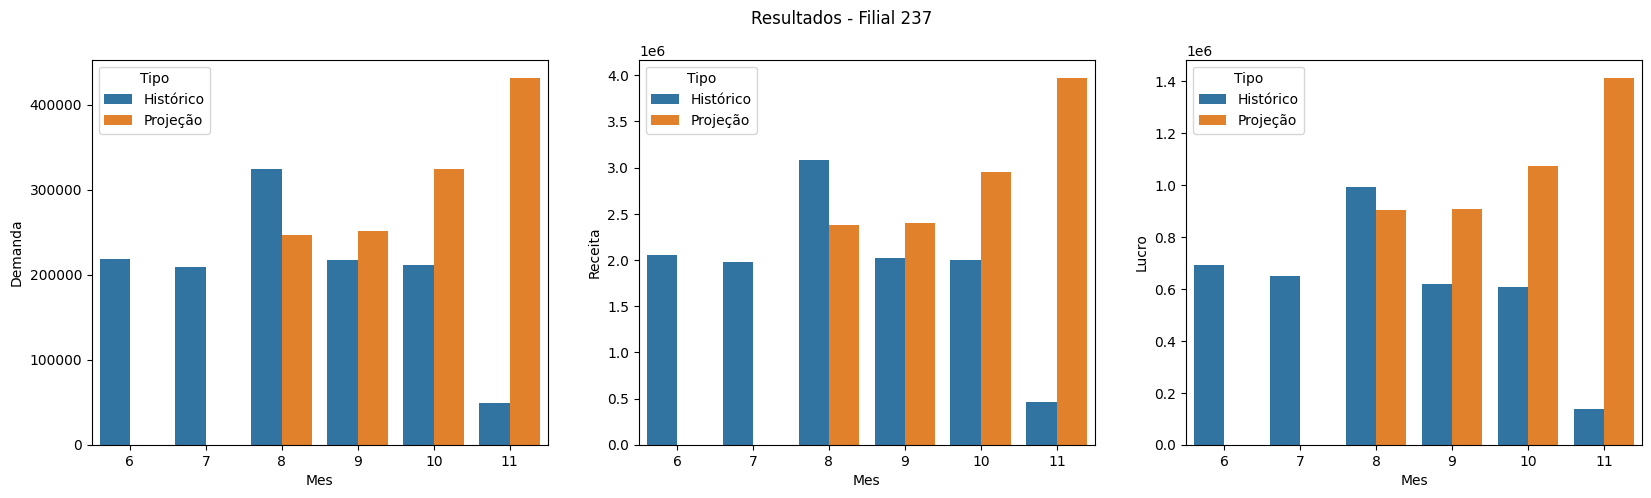

In [10]:
plt.figure(figsize=(20, 5), dpi=100)

plt.subplot(1, 3, 1)
sns.barplot(df, x="Mes", y="Demanda", hue="Tipo", estimator="sum", errorbar=None)

plt.subplot(1, 3, 2)
sns.barplot(df, x="Mes", y="Receita", hue="Tipo", estimator="sum", errorbar=None)

plt.subplot(1, 3, 3)
sns.barplot(df, x="Mes", y="Lucro", hue="Tipo", estimator="sum", errorbar=None)

plt.suptitle("Resultados - Filial 237")
plt.show()